## Q4

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
## importing dataframe
df = pd.DataFrame({
    'Age': [20, 18, 11, 31, 22, 21, 13, 15, 16, 17],
    'like Rowing': [1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
    'Experience': [0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
    'Income': [20, 33, 21, 9, 7, 10, 23, 16, 15, 6],
    'Y': [0, 0, 1, 1, 1, 0, 1, 0, 1, 0]
})

df

,Age,like Rowing,Experience,Income,Y
0,20,1,0,20,0
1,18,1,1,33,0
2,11,0,1,21,1
3,31,0,0,9,1
4,22,1,1,7,1
5,21,1,0,10,0
6,13,1,0,23,1
7,15,1,1,16,0
8,16,0,1,15,1
9,17,1,0,6,0


### Q4.1-4.2

In [25]:
## calculate g(x) & f(x) 

theta = [0.05, -3, 2.1, 0.008]
g_values = []
f_values = []

for i in range(df.shape[0]):
    point = df.iloc[i, :-1]
    g_value = np.dot(theta, point) +0.3
    g_values.append(g_value)
    
g_values = np.array(g_values)
f_values = (np.exp(g_values) - np.exp(-g_values)) / (np.exp(g_values) + np.exp(-g_values))
    
df_clf = df
df_clf['g(x)'] = g_values
df_clf['f(x)'] = f_values

df_clf

,Age,like Rowing,Experience,Income,Y,g(x),f(x)
0,20,1,0,20,0,-1.540,-0.912120
1,18,1,1,33,0,0.564,0.510939
2,11,0,1,21,1,3.118,0.996092
3,31,0,0,9,1,1.922,0.958082
4,22,1,1,7,1,0.556,0.505004
5,21,1,0,10,0,-1.570,-0.917026
6,13,1,0,23,1,-1.866,-0.953230
7,15,1,1,16,0,0.278,0.271053
8,16,0,1,15,1,3.320,0.997389
9,17,1,0,6,0,-1.802,-0.947013


In [26]:

def calc_thresh(classifier, df_clf):

    n = df_clf.shape[0]
    
    # sort from small to large
    thresholds = sorted(df_clf[classifier].unique())  

    errors = []

    for thresh in thresholds:
        pred_labels = df_clf[classifier].apply(lambda x: 1 if x >= thresh else 0)

        ## calculate masclassification error
        error = sum(pred_labels != df_clf['Y']) / n

        errors.append((thresh, error))

    min_error = min(errors, key=lambda x: x[1])[1]
    optimal_thresholds = [thresh for thresh, error in errors if error == min_error]
    
    return optimal_thresholds

In [27]:
## results threshhold 
## select the largest threshhold (there will be 2 thresh that result in min_error)
print(f"The largest threshold value that would minimize (mis)classification error "
      f"for classifier g(x) is { max(calc_thresh('g(x)', df_clf)) }") 

print(f"The largest threshold value that would minimize (mis)classification error "
      f"for classifier f(x) is { max(calc_thresh('f(x)', df_clf)) }")


The largest threshold value that would minimize (mis)classification error for classifier g(x) is 1.9220000000000002
The largest threshold value that would minimize (mis)classification error for classifier f(x) is 0.9580817795055406


In [28]:
## confusion matrix, precision, recall, and F1 score for f(x)

clf_f = max(calc_thresh('f(x)', df_clf))

df_clf['Y^'] = df_clf['f(x)'].apply(lambda x: 1 if x >= clf_f else 0)

TP = sum((df_clf['Y^'] == df_clf['Y']) & (df_clf['Y^'] == 1))
FP = sum((df_clf['Y^'] != df_clf['Y']) & (df_clf['Y^'] == 1))
FN = sum((df_clf['Y^'] != df_clf['Y']) & (df_clf['Y^'] == 0))
TN = sum((df_clf['Y^'] == df_clf['Y']) & (df_clf['Y^'] == 0))

## confusion matrix
CM = [[TP, FP], [FN, TN]]
print(f'Confusion matrix is {CM}')

## recall
Recall = TP/(TP+FN)
print(f'Recall is {Recall}')  

## Precision
Precision = TP/(TP+FP)
print(f'Precision is {Precision}') 

## F1-score
F1 = 2*Precision*Recall/(Precision + Recall)
print(f'F1-score is {F1}')

Confusion matrix is [[3, 0], [2, 5]]
Recall is 0.6
Precision is 1.0
F1-score is 0.7499999999999999


### Q4.3-4.4

In [29]:
def roc_prepare(df, classifier):
    
    df_pred = df
    
    thresholds = sorted(df_pred[classifier].unique()) 
    max_thresh = max(thresholds)
    thresholds.append(max_thresh + 1)   ## Note: the point (0,0) is represent the largest thresh results
    
    optimal_thresholds = calc_thresh(classifier, df_clf)
    
    prev_TPR = 1  # classifier start from the right side
    prev_FPR = 1
    AUC = 0
    
    fpr_tpr = []
    optimal_fpr_tpr = []
    
    for thresh in thresholds:
            
        df_pred['Y^'] = df_pred[classifier].apply(lambda x: 1 if x >= thresh else 0)
        
        TP = sum((df_pred['Y'] == 1) & (df_pred['Y^'] == 1))
        FN = sum((df_pred['Y'] == 1) & (df_pred['Y^'] == 0))
        FP = sum((df_pred['Y'] == 0) & (df_pred['Y^'] == 1))
        TN = sum((df_pred['Y'] == 0) & (df_pred['Y^'] == 0))

        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)  ## TNR
        
        AUC += (prev_FPR - FPR) * TPR
        prev_FPR = FPR
        prev_TPR = TPR

        fpr_tpr.append((thresh, FPR, TPR)) ## x = fpr, y = tpr
        
        if thresh in optimal_thresholds:
            optimal_fpr_tpr.append((thresh, FPR, TPR))

    return AUC, fpr_tpr, optimal_fpr_tpr


In [30]:
def roc_plot(df, classifier):
    
    AUC, fpr_tpr, optimal_fpr_tpr = roc_prepare(df, classifier)
    
    fpr_tpr_df = pd.DataFrame(fpr_tpr, columns=['Threshold', 'FPR', 'TPR'])
    optimal_fpr_tpr_df = pd.DataFrame(optimal_fpr_tpr, columns=['Threshold', 'FPR', 'TPR'])

    sns.set_theme()
    plt.figure(figsize=(10, 7))
    plt.plot(fpr_tpr_df['FPR'], fpr_tpr_df['TPR'], marker='o', linestyle='-', color="#fd7f6f", zorder=1)
    plt.scatter(optimal_fpr_tpr_df['FPR'], optimal_fpr_tpr_df['TPR'], color='red', 
                s=100, marker='^', label='Optimal Thresholds', zorder=2)      
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{classifier} ROC Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

 ## what we mean by optimal Thresholds means taht it is the threshold that minimize the misclassification error

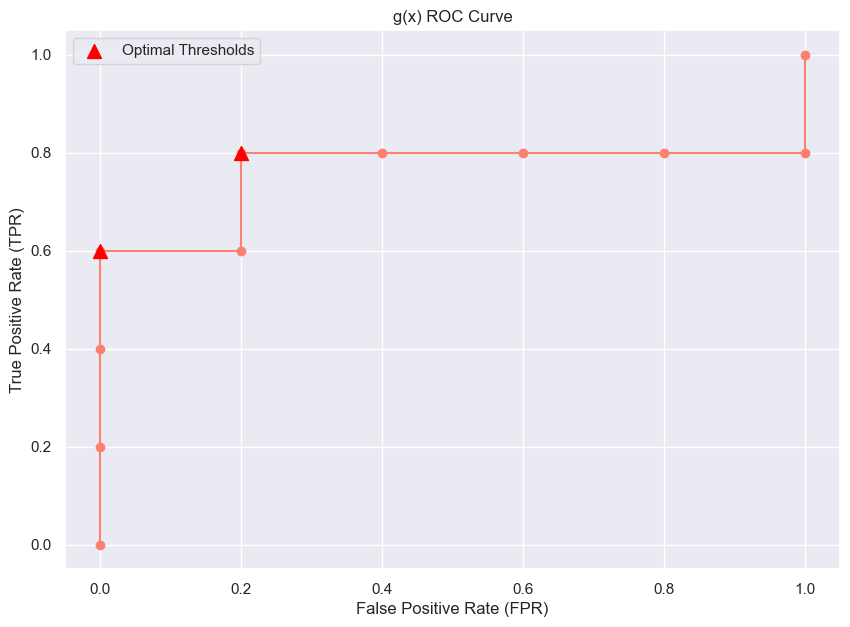

In [31]:
roc_plot(df_clf, 'g(x)')   

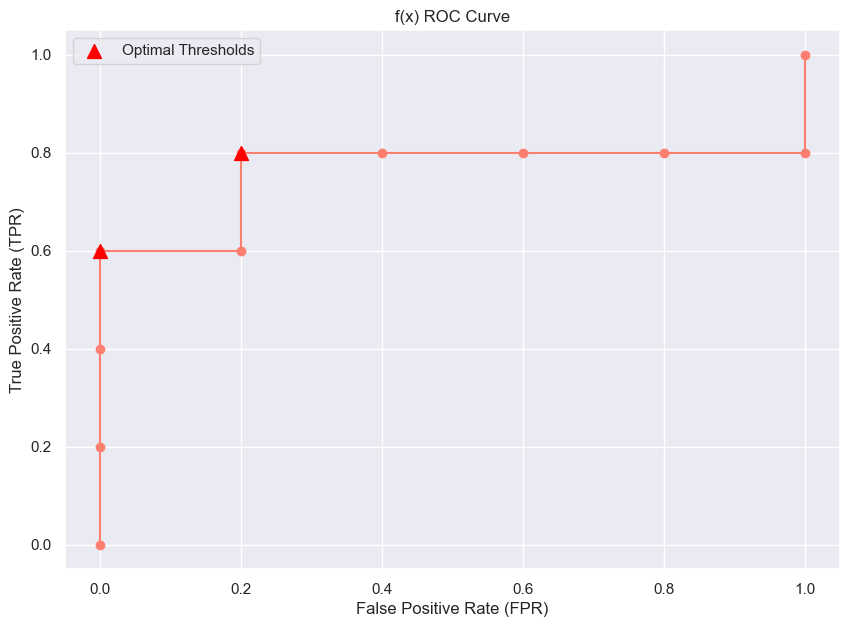

In [32]:
roc_plot(df_clf, 'f(x)')

In [33]:
AUC_g, fpr_tpr, optimal_fpr_tpr= roc_prepare(df_clf, 'g(x)')
print(f'AUC for classifier g(x) is {AUC_g}')
AUC_f, fpr_tpr, optimal_fpr_tpr = roc_prepare(df_clf, 'f(x)')
print(f'AUC for classifier f(x) is {AUC_f}')

AUC for classifier g(x) is 0.7600000000000001
AUC for classifier f(x) is 0.7600000000000001
